- 먼저 final_48m.zip 파일을 받아 압축을 풀어 xray라는 디렉토리 안에 넣어두고, xray 디렉토리 바로 밖에서 이 코드를 실행하시면 됩니다

In [28]:
from glob import glob
import os
import shutil
from tqdm import tqdm

In [29]:
os.makedirs("./xray/mask", exist_ok=True)
os.makedirs("./xray/roi", exist_ok=True)
os.makedirs("./xray/png", exist_ok=True)

In [30]:
for mask in glob("xray/*mask.png"):
    shutil.move(mask, f"xray/mask/{mask.split('/')[-1]}")

In [31]:
for roi in glob("xray/*.roi"):
    shutil.move(roi, f"xray/roi/{roi.split('/')[-1]}")

In [32]:
for png in glob("xray/*.png"):
    shutil.move(png, f"xray/png/{png.split('/')[-1]}")

In [33]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

In [36]:
xray_lst = sorted(glob("xray/png/*.png"))
mask_lst = sorted(glob("xray/mask/*.png"))

In [39]:
sample_xray = np.array(Image.open(xray_lst[0]))
sample_mask = np.array(Image.open(mask_lst[0]))

IndexError: list index out of range

In [ ]:
sample_xray

In [ ]:
plt.imshow(sample_xray, cmap='gray')

In [12]:
for xray in xray_lst:
    xray

In [13]:
sample_mask

array([[21, 21, 21, ..., 20, 20, 20],
       [21, 21, 21, ..., 20, 20, 20],
       [21, 21, 21, ..., 20, 20, 20],
       ...,
       [21, 21, 21, ..., 21, 21, 21],
       [21, 21, 21, ..., 22, 22, 22],
       [21, 21, 21, ..., 22, 22, 22]], dtype=uint8)

- mask_png 파일이 binary_map 이 아닙니다. 따라서 threshold 값을 정해 binray로 만들어주어야 합니다.

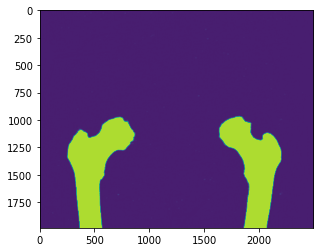

In [14]:
plt.imshow(sample_mask)

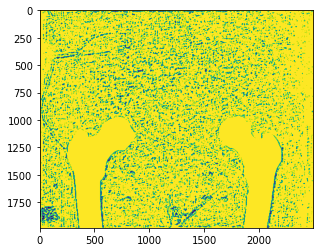

In [15]:
plt.imshow(sample_mask>20)

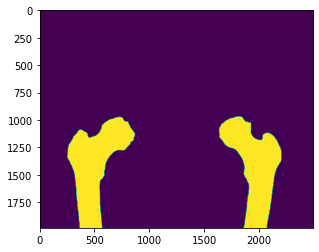

In [16]:
plt.imshow(sample_mask>100) # 이 값으로 pick!

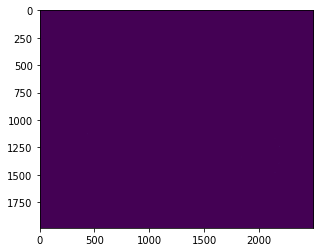

In [17]:
plt.imshow(sample_mask>250)

In [18]:
def horizontal_plot(num, *imgs, size=(20,20), cmap=None):  
    plt.figure()
    plt.rcParams["figure.figsize"] = size

    f, axarr = plt.subplots(1, num)

    for n in range(num):
        axarr[n].imshow(imgs[n], cmap=cmap)
        axarr[n].axis('off')

    plt.show()
    
def toarr(path):
    return np.array(Image.open(path))

<Figure size 432x288 with 0 Axes>

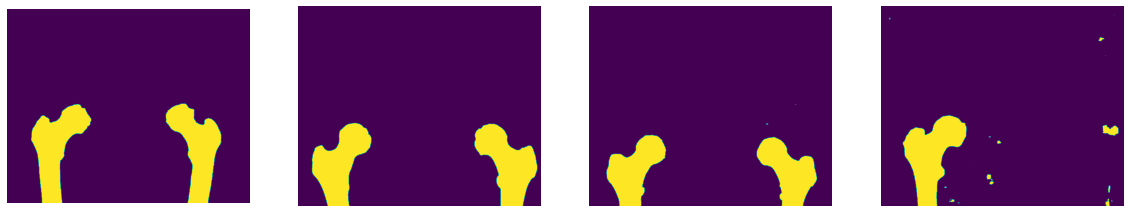

In [19]:
th = 100
for idx in range(len(mask_lst)//4):
    horizontal_plot(4, toarr(mask_lst[idx])>th, toarr(mask_lst[idx+1])>th, toarr(mask_lst[idx+2])>th, toarr(mask_lst[idx+3])>th)
    break

- 결과가 썩 좋지 않습니다. 다른 방법을 사용해야겠습니다.

- .roi 파일을 이용합니다.

In [20]:
!pip install read_roi

  Created wheel for read-roi: filename=read_roi-1.6.0-py2.py3-none-any.whl size=8028 sha256=3c021244017103ac1bf70cae2fdb98289dbf7219b65bc47da648114cae6336df
  Stored in directory: /root/.cache/pip/wheels/03/1a/3a/54295445484a9e819007ee1d440e2d76e27a1c6a04bd39cf6a
Successfully built read-roi
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [41]:
from read_roi import read_roi_file
import cv2

In [42]:
roi_lst = sorted(glob("xray/roi/*.roi"))
sample_roi = read_roi_file(roi_lst[0])

In [23]:
sample_roi

{'9004905_mask': {'type': 'composite',
  'left': 248,
  'top': 975,
  'width': 1947,
  'height': 1009,
  'paths': [[(689.0, 978.0),
    (689.0, 979.0),
    (686.0, 979.0),
    (686.0, 980.0),
    (683.0, 980.0),
    (683.0, 981.0),
    (682.0, 981.0),
    (682.0, 982.0),
    (680.0, 982.0),
    (680.0, 983.0),
    (675.0, 983.0),
    (675.0, 984.0),
    (671.0, 984.0),
    (671.0, 985.0),
    (669.0, 985.0),
    (669.0, 986.0),
    (667.0, 986.0),
    (667.0, 987.0),
    (666.0, 987.0),
    (666.0, 988.0),
    (664.0, 988.0),
    (664.0, 989.0),
    (663.0, 989.0),
    (663.0, 990.0),
    (661.0, 990.0),
    (661.0, 991.0),
    (658.0, 991.0),
    (658.0, 992.0),
    (648.0, 992.0),
    (648.0, 993.0),
    (645.0, 993.0),
    (645.0, 994.0),
    (642.0, 994.0),
    (642.0, 995.0),
    (639.0, 995.0),
    (639.0, 996.0),
    (635.0, 996.0),
    (635.0, 997.0),
    (633.0, 997.0),
    (633.0, 998.0),
    (630.0, 998.0),
    (630.0, 999.0),
    (627.0, 999.0),
    (627.0, 1000.0),
    (62

In [1]:
list(sample_roi.keys())

NameError: name 'sample_roi' is not defined

In [108]:
sample_roi[list(sample_roi.keys())[0]].keys()

dict_keys(['type', 'left', 'top', 'width', 'height', 'paths', 'name', 'position'])

In [118]:
roi_shape = toarr(xray_lst[0]).shape

In [119]:
cnt = sample_roi[list(sample_roi.keys())[0]]['paths']

In [16]:
def cnt2mask(cnt, shape):
    mask = np.zeros(shape, dtype=np.uint8)
    for c in cnt:
        mask_pts = np.array(c).reshape((-1, 1, 2)).astype(np.int32)
        cv2.fillPoly(mask, [mask_pts], 1)
    return mask

In [129]:
mask = cnt2mask(cnt, roi_shape)

In [24]:
plt.imshow(mask)

NameError: name 'mask' is not defined

In [147]:
os.makedirs("./xray/mask_roi", exist_ok=True)
for idx in tqdm(range(len(roi_lst))):
    sample_roi = read_roi_file(roi_lst[idx])
    roi_shape = toarr(xray_lst[idx]).shape
    
    if sample_roi[list(sample_roi.keys())[0]]['type'] == "composite":
        cnt = sample_roi[list(sample_roi.keys())[0]]['paths']
    elif sample_roi[list(sample_roi.keys())[0]]['type'] == "traced":
        print(idx)
        continue
#         cnt = sample_roi[list(sample_roi.keys())[0]]['paths']
    else:
        print(sample_roi[list(sample_roi.keys())[0]]['type'])
        print(idx)
        break
    
    mask = cnt2mask(cnt, roi_shape)
    
    Image.fromarray(mask).resize((512, roi_shape[0]*512//roi_shape[1])).save(f"./xray/mask_roi/{roi_lst[idx].split('/')[-1].split('.')[0]}.png")

  1%|▏         | 4/267 [00:00<00:53,  4.95it/s]

3


 79%|███████▉  | 211/267 [00:53<00:12,  4.37it/s]

209


 81%|████████▏ | 217/267 [00:54<00:11,  4.40it/s]

216


100%|██████████| 267/267 [01:06<00:00,  4.00it/s]


In [138]:
sample_roi[list(sample_roi.keys())[0]].keys()

dict_keys(['type', 'x', 'y', 'n', 'width', 'name', 'position'])

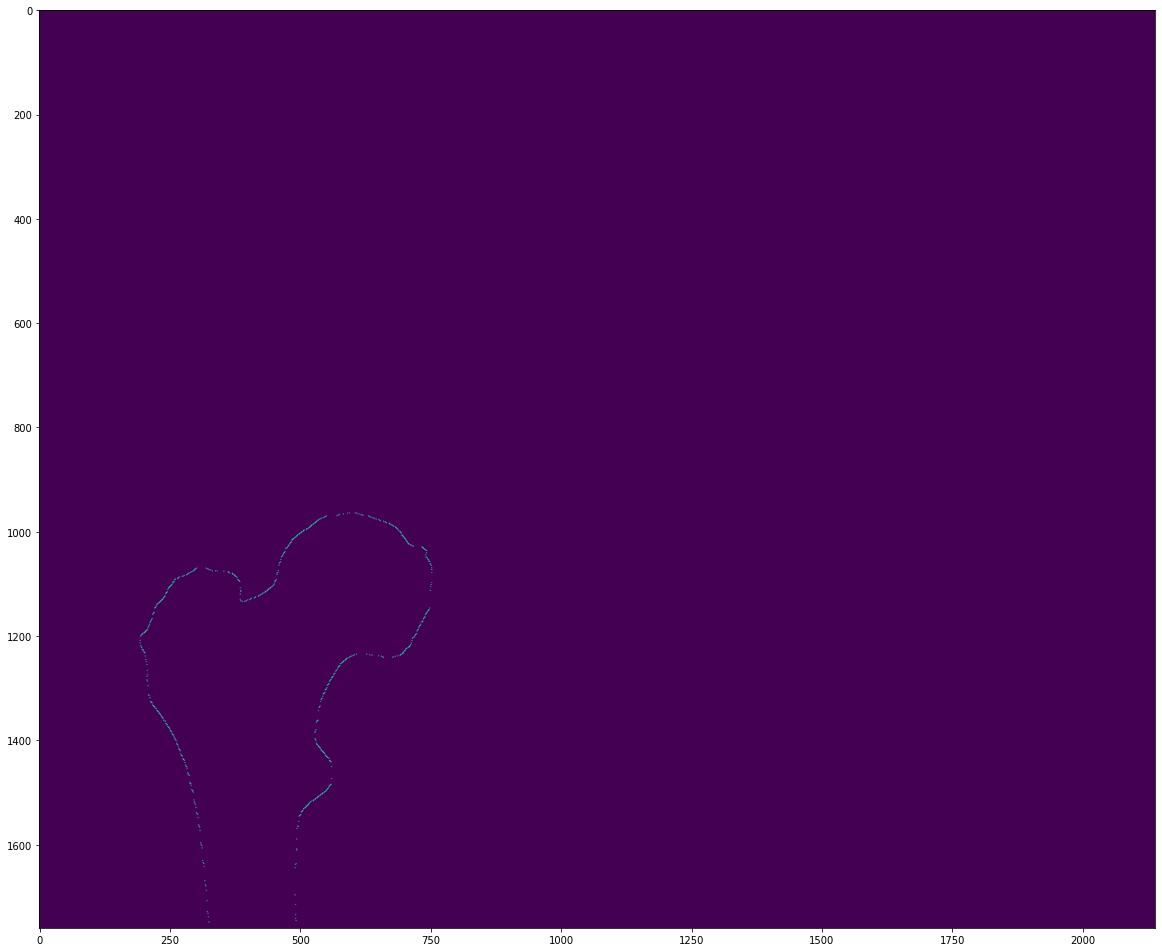

In [146]:
plt.imshow(traced_mask)

In [69]:
mask_roi_lst = sorted(glob("xray/mask_roi/*.png"))

<Figure size 432x288 with 0 Axes>

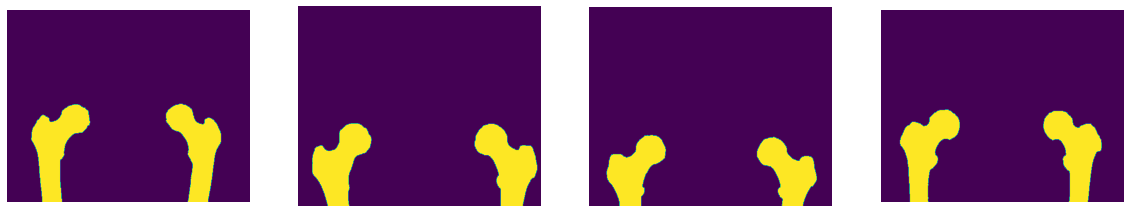

<Figure size 1440x1440 with 0 Axes>

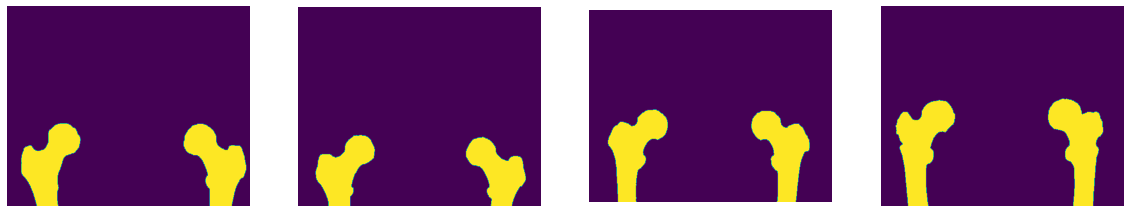

<Figure size 1440x1440 with 0 Axes>

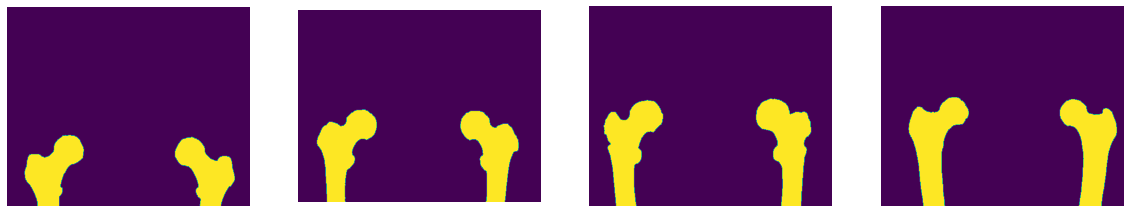

<Figure size 1440x1440 with 0 Axes>

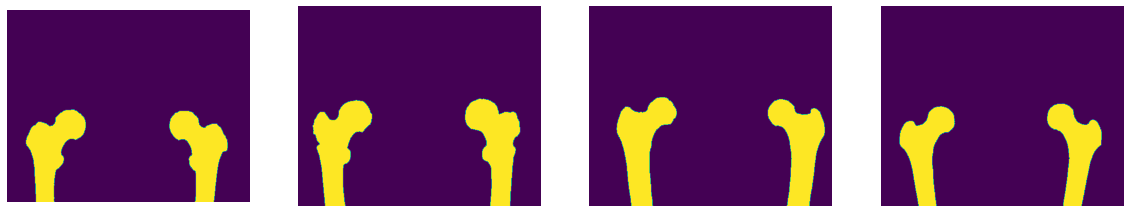

<Figure size 1440x1440 with 0 Axes>

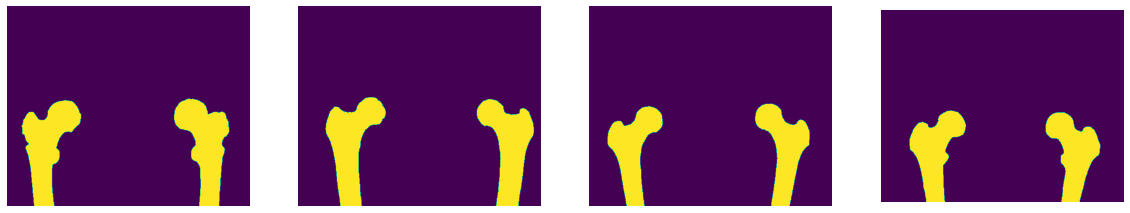

<Figure size 1440x1440 with 0 Axes>

In [ ]:
for idx in range(len(mask_roi_lst)//4):
    horizontal_plot(4, toarr(mask_roi_lst[idx]), toarr(mask_roi_lst[idx+1]), toarr(mask_roi_lst[idx+2]), toarr(mask_roi_lst[idx+3]))

In [18]:
array = toarr(mask_roi_lst[0])

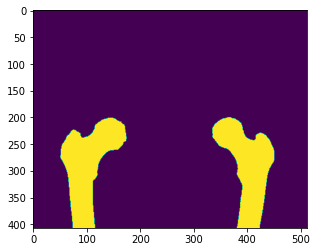

In [19]:
plt.imshow(array)

In [31]:
cnt_wsi_arr = array.copy()
cnt_wsi_arr = cv2.cvtColor(cnt_wsi_arr, cv2.COLOR_RGB2BGR)

contours, _ = cv2.findContours(array, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
for c in contours:    
    line_colour = (0,0,255)
    line_thickness = 3
    cv2.drawContours(cnt_wsi_arr,[c],-1,line_colour,line_thickness)

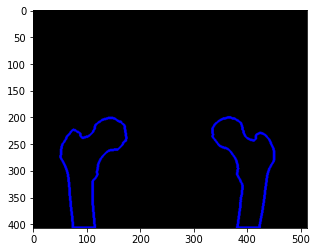

In [32]:
plt.imshow(cnt_wsi_arr)

In [34]:
mask_roi_lst[0]

'xray/mask_roi/9004905_mask.png'

In [40]:
def mask2cnt(path):
    array = toarr(path)
    xray = toarr(f"xray/png/{path.split('/')[-1].split('_')[0]}.png")
    cnt_xray_arr = xray.copy()
    cnt_xray_arr = cv2.cvtColor(cnt_xray_arr, cv2.COLOR_GRAY2BGR)

    contours, _ = cv2.findContours(array, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    for c in contours:    
        line_colour = (0,0,255)
        line_thickness = 10
        cv2.drawContours(cnt_xray_arr,[c],-1,line_colour,line_thickness)
    return cnt_xray_arr

In [41]:
for idx in range(len(mask_roi_lst)//4):
    horizontal_plot(4, mask2cnt(mask_roi_lst[idx]), mask2cnt(mask_roi_lst[idx+1]), mask2cnt(mask_roi_lst[idx+2]), mask2cnt(mask_roi_lst[idx+3]))

error: OpenCV(4.5.2) /tmp/pip-req-build-lnehsv18/opencv/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<1>; VDcn = cv::impl::{anonymous}::Set<3, 4>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 4 (CV_32S)


In [82]:
for m in tqdm(mask_roi_lst):
    image = Image.open(m.replace("mask_roi", "png").replace("_mask", ""))
    image.thumbnail((512,512))
    
    arr = np.array(image)
    
    arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
    
    blank = np.zeros((512, 512))
    if arr.shape[0] != 512:
        blank[-arr.shape[0]:] = arr
    elif arr.shape[1] !=512:
        blank[:, -arr.shape[1]:] = arr
    
    Image.fromarray(np.array(blank*255).astype(np.uint8)).save(m.replace("mask_roi", "png_512").replace("_mask", ""))

100%|██████████| 264/264 [01:12<00:00,  3.65it/s]


In [79]:
for m in tqdm(mask_roi_lst):
    image = Image.open(m)
    image.thumbnail((512,512))
    
    arr = np.array(image)
        
    blank = np.zeros((512, 512))
    if arr.shape[0] != 512:
        blank[-arr.shape[0]:] = arr
    elif arr.shape[1] !=512:
        blank[:, -arr.shape[1]:] = arr
    
    Image.fromarray(blank.astype(np.uint8)).save(m.replace("mask_roi", "mask_512"))

100%|██████████| 264/264 [00:01<00:00, 134.16it/s]


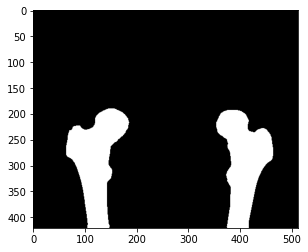

In [73]:
plt.imshow(arr, cmap='gray')

In [53]:
image.thumbnail((512,512))

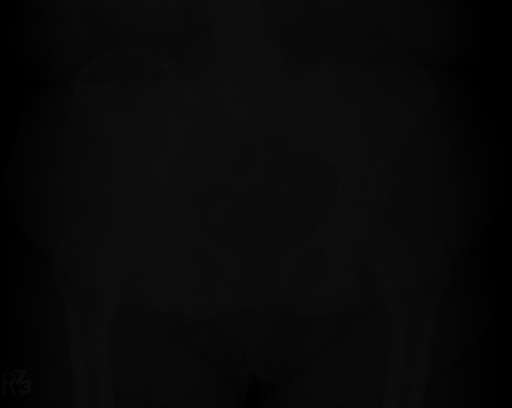

In [54]:
image

In [55]:
arr = np.array(image)

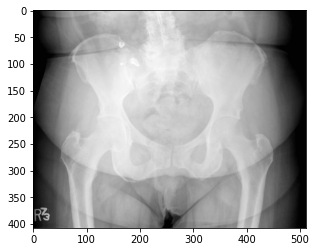

In [58]:
plt.imshow(arr, cmap='gray')

In [59]:
arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

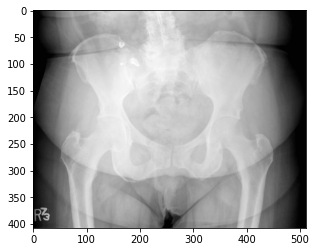

In [60]:
plt.imshow(arr, cmap='gray')